In [1]:
import normflows as nf
import matplotlib.pyplot as plt
import torch
import numpy as np

from fab import FABModel, HamiltonianMonteCarlo, Metropolis
from fab.utils.logging import ListLogger
from fab.utils.plotting import plot_history, plot_contours, plot_marginal_pair
from dpp import DPP
from fab.utils.prioritised_replay_buffer import PrioritisedReplayBuffer
from fab import Trainer, PrioritisedBufferTrainer
from fab.utils.plotting import plot_contours, plot_marginal_pair

from experiments.make_flow import make_wrapped_normflow_realnvp
from tqdm import tqdm

import seaborn as sns
sns.set()
sns.set_style("ticks")
sns.set_context("paper", font_scale = 2.0)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 25

## Setup Target distribution

In [2]:
dim = 2
seed = 0

In [3]:
torch.manual_seed(0)  # seed of 0 for GMM problem
target = DPP(dim=dim, use_gpu=True, data='D_Kspipi_SDP_1e7.npy', true_expectation_estimation_n_samples=int(1e5)).detach()

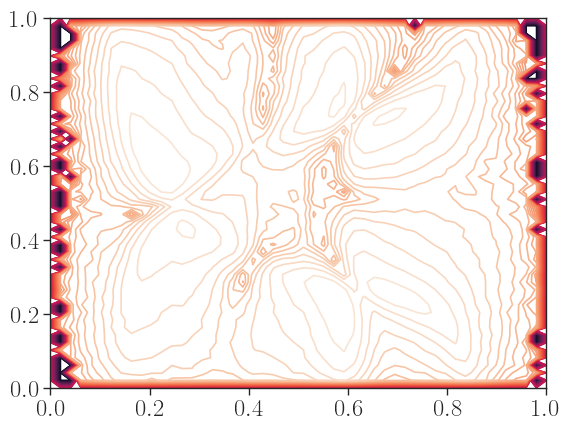

In [4]:
# plot target
target.to("cpu")
fig, ax = plt.subplots()
plotting_bounds = ((0,1))
log_prob = torch.from_numpy(np.log(self.density(x))).detach()
plot_contours(target.log_prob, bounds = plotting_bounds, n_contour_levels=60, ax=ax, grid_width_n_points=50)
target.to("cuda")

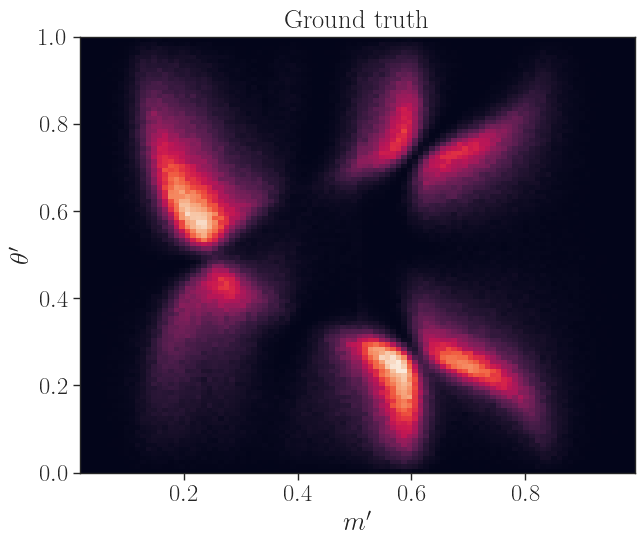

In [5]:
samples_gt = target.sample(1000000)
samples_gt = samples_gt.detach().numpy()

fig, ax = plt.subplots(1,1,figsize=(7,6))
ax.hist2d(samples_gt[:,0], samples_gt[:,1], 100)
ax.set_xlabel(r"$m'$")
ax.set_ylabel(r"$\theta'$")
ax.set_title(r'$\mathrm{Ground}$ $\mathrm{truth}$')
fig.tight_layout()

## Reinitialize FAB model

### Model v1

In [80]:
# Define the flow
n_flow_layers = 20
layer_nodes_per_dim = 40
lr = 1e-4
max_gradient_norm = 100.0
batch_size = 4096
n_iterations = 4000
n_eval = 10
eval_batch_size = batch_size * 10
n_plots = 25 # Number of plots shows throughout tranining
use_64_bit = True
alpha = 2.0

# AIS
# By default we use a simple metropolis mcmc transition with a fixed step size.
# Can switch this to 'hmc' to improve training efficiency. 
transition_operator_type = "metropolis" 
n_intermediate_distributions = 7
metropolis_step_size = 0.1

# buffer config
n_batches_buffer_sampling = 5
maximum_buffer_length = batch_size * n_batches_buffer_sampling * 100
min_buffer_length = batch_size * n_batches_buffer_sampling * 10

# target p^\alpha q^{a-\alpha} as target for AIS. 
min_is_target = True
p_target = not min_is_target # Whether to use p as the target.

## Model v2

In [6]:
# Define the flow
n_flow_layers = 20
layer_nodes_per_dim = 40
lr = 1e-4
max_gradient_norm = 100.0
batch_size = 4096
n_iterations = 4000
n_eval = 10
eval_batch_size = batch_size * 10
n_plots = 25 # Number of plots shows throughout tranining
use_64_bit = True
alpha = 2.0

# AIS
# By default we use a simple metropolis mcmc transition with a fixed step size.
# Can switch this to 'hmc' to improve training efficiency. 
transition_operator_type = "metropolis" 
n_intermediate_distributions = 4
metropolis_step_size = 0.2

# buffer config
n_batches_buffer_sampling = 5
maximum_buffer_length = batch_size * n_batches_buffer_sampling * 100
min_buffer_length = batch_size * n_batches_buffer_sampling * 10

# target p^\alpha q^{a-\alpha} as target for AIS. 
min_is_target = True
p_target = not min_is_target # Whether to use p as the target.

## Model v3

In [6]:
# Define the flow
n_flow_layers = 20
layer_nodes_per_dim = 40
lr = 1e-4
max_gradient_norm = 100.0
batch_size = 8192
n_iterations = 1000
n_eval = 10
eval_batch_size = batch_size * 10
n_plots = 25 # Number of plots shows throughout tranining
use_64_bit = True
alpha = 2.0

# AIS
# By default we use a simple metropolis mcmc transition with a fixed step size.
# Can switch this to 'hmc' to improve training efficiency. 
transition_operator_type = "metropolis" 
n_intermediate_distributions = 5
metropolis_step_size = 0.2

# buffer config
n_batches_buffer_sampling = 5
maximum_buffer_length = batch_size * n_batches_buffer_sampling * 100
min_buffer_length = batch_size * n_batches_buffer_sampling * 10

# target p^\alpha q^{a-\alpha} as target for AIS. 
min_is_target = True
p_target = not min_is_target # Whether to use p as the target. 

In [6]:
# For D_pipipi_SDP_3

# Define the flow
n_flow_layers = 25
layer_nodes_per_dim = 50
lr = 1e-4
max_gradient_norm = 100.0
batch_size = 4096
n_iterations = 2000
n_eval = 10
eval_batch_size = batch_size * 10
n_plots = 25 # Number of plots shows throughout tranining
use_64_bit = True
alpha = 2.0

# AIS
# By default we use a simple metropolis mcmc transition with a fixed step size.
# Can switch this to 'hmc' to improve training efficiency. 
transition_operator_type = "metropolis" 
n_intermediate_distributions = 5
metropolis_step_size = 0.2

# buffer config
n_batches_buffer_sampling = 5
maximum_buffer_length = batch_size * n_batches_buffer_sampling * 100
min_buffer_length = batch_size * n_batches_buffer_sampling * 10

# target p^\alpha q^{a-\alpha} as target for AIS. 
min_is_target = False
p_target = not min_is_target # Whether to use p as the target. 

In [6]:
# For FAB_D_pipipi_SDP_5 

# Define the flow
n_flow_layers = 25
layer_nodes_per_dim = 50
lr = 1e-4
max_gradient_norm = 100.0
batch_size = 4096
n_iterations = 2000
n_eval = 10
eval_batch_size = batch_size * 10
n_plots = 25 # Number of plots shows throughout tranining
use_64_bit = True
alpha = 2.0

# AIS
# By default we use a simple metropolis mcmc transition with a fixed step size.
# Can switch this to 'hmc' to improve training efficiency. 
transition_operator_type = "metropolis" 
n_intermediate_distributions = 7
metropolis_step_size = 0.1

# buffer config
n_batches_buffer_sampling = 5
maximum_buffer_length = batch_size * n_batches_buffer_sampling * 100
min_buffer_length = batch_size * n_batches_buffer_sampling * 10

# target p^\alpha q^{a-\alpha} as target for AIS. 
min_is_target = True
p_target = not min_is_target # Whether to use p as the target. 

In [13]:
# For FAB_Dbar_pipipi_CPV_SDP_3 # best one so far

# Define the flow
n_flow_layers = 25
layer_nodes_per_dim = 50
lr = 1e-4
max_gradient_norm = 100.0
batch_size = 4096
n_iterations = 2000
n_eval = 10
eval_batch_size = batch_size * 10
n_plots = 25 # Number of plots shows throughout tranining
use_64_bit = True
alpha = 2.0

# AIS
# By default we use a simple metropolis mcmc transition with a fixed step size.
# Can switch this to 'hmc' to improve training efficiency. 
transition_operator_type = "metropolis" 
n_intermediate_distributions = 8
metropolis_step_size = 0.1

# buffer config
n_batches_buffer_sampling = 5
maximum_buffer_length = batch_size * n_batches_buffer_sampling * 100
min_buffer_length = batch_size * n_batches_buffer_sampling * 10

# target p^\alpha q^{a-\alpha} as target for AIS. 
min_is_target = True
p_target = not min_is_target # Whether to use p as the target. 

In [6]:
# For FAB_D_pipipi_SDP_6

# Define the flow
n_flow_layers = 25
layer_nodes_per_dim = 50
lr = 1e-4
max_gradient_norm = 100.0
batch_size = 4096
n_iterations = 2000
n_eval = 10
eval_batch_size = batch_size * 10
n_plots = 25 # Number of plots shows throughout tranining
use_64_bit = True
alpha = 2.0

# AIS
# By default we use a simple metropolis mcmc transition with a fixed step size.
# Can switch this to 'hmc' to improve training efficiency. 
transition_operator_type = "metropolis" 
n_intermediate_distributions = 8
metropolis_step_size = 0.075

# buffer config
n_batches_buffer_sampling = 5
maximum_buffer_length = batch_size * n_batches_buffer_sampling * 100
min_buffer_length = batch_size * n_batches_buffer_sampling * 10

# target p^\alpha q^{a-\alpha} as target for AIS. 
min_is_target = True
p_target = not min_is_target # Whether to use p as the target. 

In [7]:
if use_64_bit:
    torch.set_default_dtype(torch.float64)
    target = target.double()
    print(f"running with 64 bit")

running with 64 bit


### Setup flow

In [8]:
# Define the flow
flow = make_wrapped_normflow_realnvp(dim, n_flow_layers=n_flow_layers, 
                                     layer_nodes_per_dim=layer_nodes_per_dim,
                                     act_norm=False, 
                                     boundaries=False)

In [9]:
# Define the transistion operator
if transition_operator_type == "hmc":
    # very lightweight HMC.
    transition_operator = HamiltonianMonteCarlo(
            n_ais_intermediate_distributions=n_intermediate_distributions,
            dim=dim,
            base_log_prob=flow.log_prob,
            target_log_prob=target.log_prob,
            alpha=alpha,
            p_target=p_target,
        n_outer=1,
        epsilon=1.0, L=5)
elif transition_operator_type == "metropolis":
    transition_operator = Metropolis(            
        n_ais_intermediate_distributions=n_intermediate_distributions,
        dim=dim,
        base_log_prob=flow.log_prob,
        target_log_prob=target.log_prob,
        p_target=p_target,
        alpha=alpha,
        n_updates=1,
        adjust_step_size=False,
        max_step_size=metropolis_step_size, # the same for all metropolis steps 
        min_step_size=metropolis_step_size,
        eval_mode=True)
else:
    raise NotImplementedError

In [10]:
# Define the FAB model
fab_model = FABModel(flow=flow,
                     target_distribution=target,
                     n_intermediate_distributions=n_intermediate_distributions,
                     transition_operator=transition_operator,
                     alpha=alpha)

In [14]:
# Load in the state dictionary (layer weights, etc.)
#PATH = './FAB_D_pipipi_SDP_6.pth'
PATH = 'FAB_Dbar_pipipi_CPV_SDP_3.pth'
flow.load_state_dict(torch.load(PATH))
flow.eval()

WrappedNormFlowModel(
  (_nf_model): NormalizingFlow(
    (q0): DiagGaussian()
    (flows): ModuleList(
      (0): AffineCouplingBlock(
        (flows): ModuleList(
          (0): Split()
          (1): AffineCoupling(
            (param_map): MLP(
              (net): Sequential(
                (0): Linear(in_features=1, out_features=100, bias=True)
                (1): LeakyReLU(negative_slope=0.0)
                (2): Linear(in_features=100, out_features=100, bias=True)
                (3): LeakyReLU(negative_slope=0.0)
                (4): Linear(in_features=100, out_features=2, bias=True)
              )
            )
          )
          (2): Merge()
        )
      )
      (1): InvertibleAffine()
      (2): AffineCouplingBlock(
        (flows): ModuleList(
          (0): Split()
          (1): AffineCoupling(
            (param_map): MLP(
              (net): Sequential(
                (0): Linear(in_features=1, out_features=100, bias=True)
                (1): LeakyReLU(nega

In [15]:
# Check if GPU is available
if torch.cuda.is_available():
    flow.cuda()
    transition_operator.cuda()
    target.to("cuda")
    print(f"Running with GPU")

## Ground truth

## Flow

In [22]:
n_samples = 10000
samples_flow = []
n = 0
for i in tqdm(range(100), ncols = 100):
    sample_flow = fab_model.flow.sample((n_samples,)).detach()
    #for j in range(n_samples):
        #if sample_flow[j,0] > 1.0 or sample_flow[j,0] < 0.0 or sample_flow[j,1] > 1.0 or sample_flow[j,1] < 0.0:
            #print('Element out of range.')
            #n+=1
    samples_flow.append(sample_flow)
print(n, 'elements out of range.')

100%|█████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.27it/s]

0 elements out of range.


In [23]:
samples_flow = np.array(samples_flow)
print(samples_flow.shape)
samples_flow = np.reshape(samples_flow, (samples_flow.shape[0] * samples_flow.shape[1], 2))
print(samples_flow.shape)

(100, 10000, 2)
(1000000, 2)


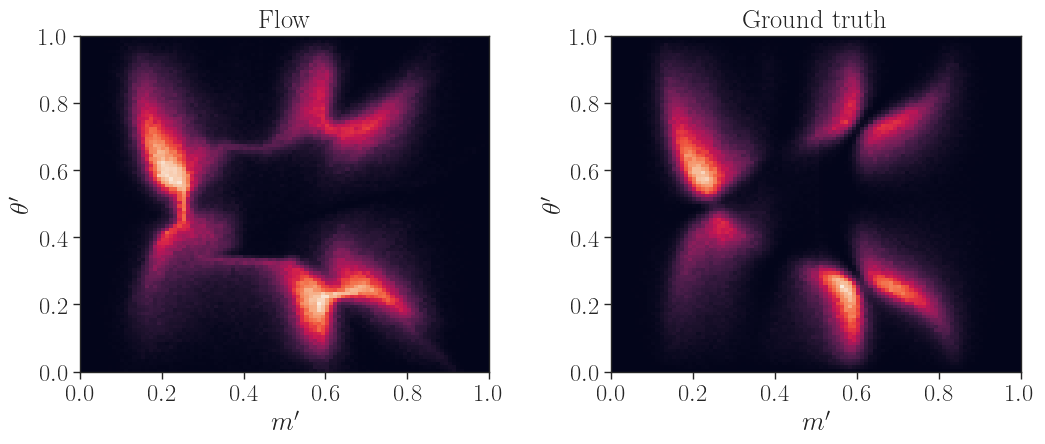

In [24]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(11,5))
H_flow, xedges, yedges, im = ax1.hist2d(samples_flow[:,0], samples_flow[:,1], 100, range = [[0,1], [0,1]])
H_gt, xedges, yedges, im = ax2.hist2d(samples_gt[:,0], samples_gt[:,1], bins = (xedges, yedges))
ax1.set_xlim(0,1)
ax1.set_ylim(0,1)
ax1.set_xlabel(r"$m'$")
ax1.set_ylabel(r"$\theta'$")
ax1.set_title(r'$\mathrm{Flow}$')
ax2.set_xlabel(r"$m'$")
ax2.set_ylabel(r"$\theta'$")
ax2.set_title(r'$\mathrm{Ground}$ $\mathrm{truth}$')
fig.tight_layout()

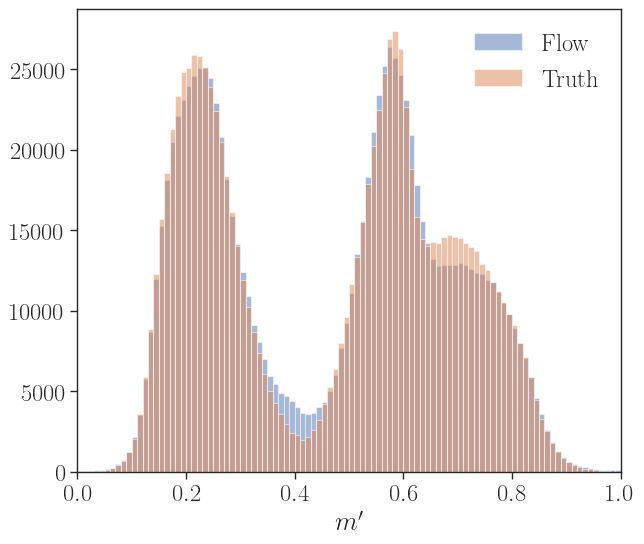

In [64]:
fig, ax = plt.subplots(1,1,figsize=(7,6))
ax.hist(samples_flow[:,0], 100, range = [0,1], alpha = 0.5, label = r'$\mathrm{Flow}$')
ax.hist(samples_gt[:,0], 100, range = [0,1], alpha = 0.5, label = r'$\mathrm{Truth}$')
ax.set_xlim(0,1)
ax.set_xlabel(r"$m'$")
ax.legend(frameon=False)
fig.tight_layout()

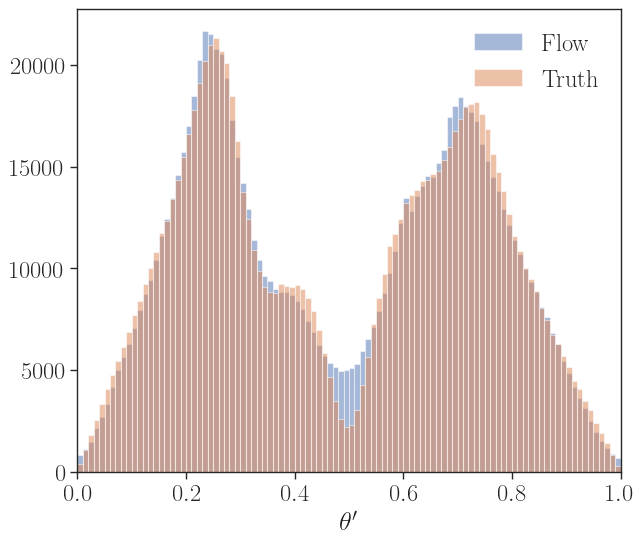

In [65]:
fig, ax = plt.subplots(1,1,figsize=(7,6))
ax.hist(samples_flow[:,1], 100, range = [0,1], alpha = 0.5, label = r'$\mathrm{Flow}$')
ax.hist(samples_gt[:,1], 100, range = [0,1], alpha = 0.5, label = r'$\mathrm{Truth}$')
ax.set_xlim(0,1)
ax.set_xlabel(r"$\theta'$")
ax.legend(frameon=False)
fig.tight_layout()

## Flow with AIS

In [16]:
n_samples = 10000
samples_ais = []
for i in tqdm(range(100), ncols = 100):
    sample_ais = fab_model.annealed_importance_sampler.sample_and_log_weights(n_samples, logging=False)[0].x.detach()
    # Check that samples are in valid range
    for j in range(n_samples):
        if sample_ais[j,0] > 1.0 or sample_ais[j,0] < 0.0 or sample_ais[j,1] > 1.0 or sample_ais[j,1] < 0.0:
            sample_ais_i = sample_ais[j]
            while sample_ais_i[0] < 1.0 and sample_ais_i[0] > 0.0 and sample_ais_i[1] < 1.0 and sample_ais_i[1] > 0.0:
                sample_ais_i = fab_model.annealed_importance_sampler.sample_and_log_weights(1, logging=False)[0].x.detach()
            sample_ais[j] = sample_ais_i[0] 
        #print(sample_ais)
    samples_ais.append(sample_ais.numpy())

100%|█████████████████████████████████████████████████████████████| 100/100 [03:57<00:00,  2.37s/it]


In [17]:
samples_ais = np.array(samples_ais)
print(samples_ais.shape)
samples_ais = np.reshape(samples_ais, (samples_ais.shape[0] * samples_ais.shape[1], 2))
print(samples_ais.shape)

(100, 10000, 2)
(1000000, 2)


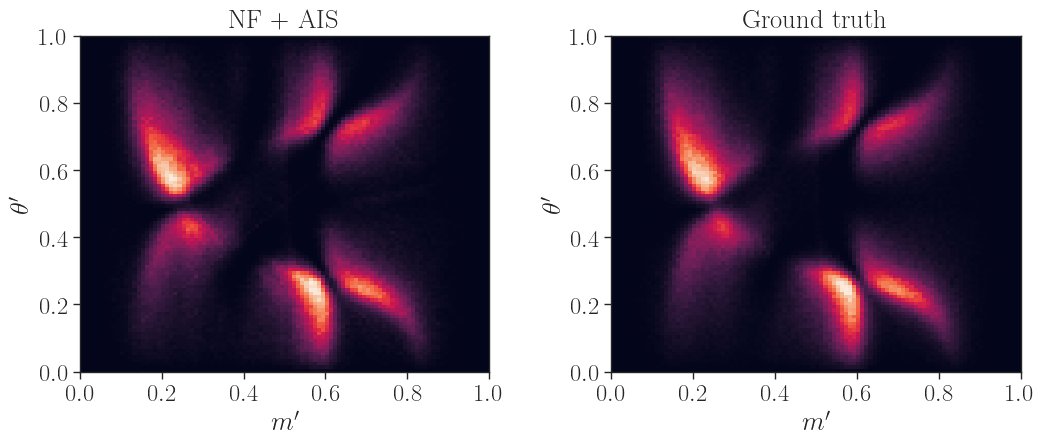

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(11,5))
H_ais, xedges, yedges, im = ax1.hist2d(samples_ais[:,0], samples_ais[:,1], 100, range = [[0,1], [0,1]])
ax2.hist2d(samples_gt[:,0], samples_gt[:,1], bins = (xedges, yedges))
ax1.set_xlim(0,1)
ax1.set_ylim(0,1)
ax1.set_xlabel(r"$m'$")
ax1.set_ylabel(r"$\theta'$")
ax1.set_title(r'$\mathrm{NF}$ $+$ $\mathrm{AIS}$')
ax2.set_xlabel(r"$m'$")
ax2.set_ylabel(r"$\theta'$")
ax2.set_title(r'$\mathrm{Ground}$ $\mathrm{truth}$')
fig.tight_layout()
fig.savefig(r'NF_AIS_vs_truth.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

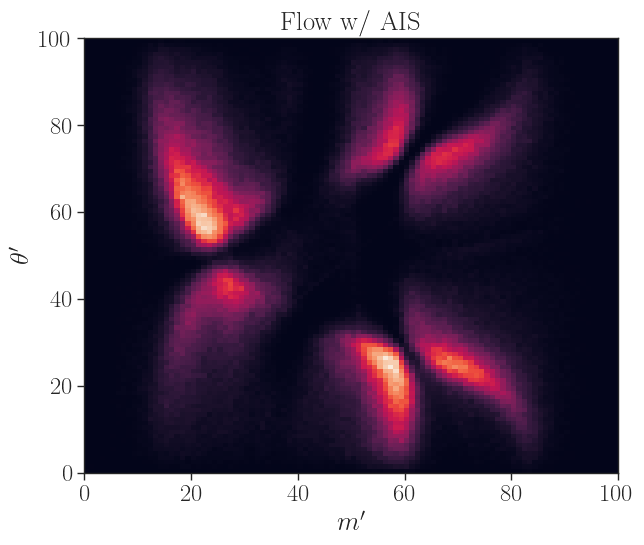

In [28]:
fig, ax = plt.subplots(1,1,figsize=(7,6))
ax.pcolormesh(H_ais.T)
#ax.set_xlim(0,1)
#ax.set_ylim(0,1)
ax.set_xlabel(r"$m'$")
ax.set_ylabel(r"$\theta'$")
ax.set_title(r'$\mathrm{Flow}$ $\mathrm{w/}$ $\mathrm{AIS}$')
fig.tight_layout()

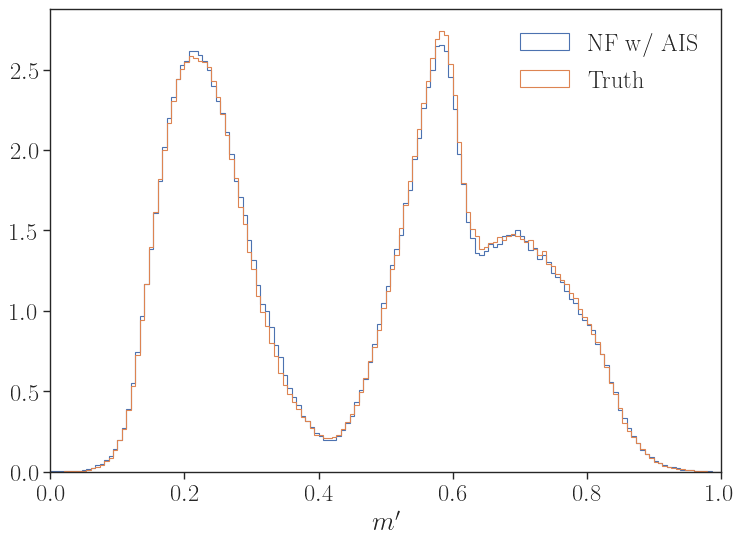

In [19]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
counts, edges, _ = ax.hist(samples_ais[:,0], 150, range = [0,1], histtype = 'step', label = r'$\mathrm{NF}$ $\mathrm{w/}$ $\mathrm{AIS}$', density=True)
ax.hist(samples_gt[:,0], bins = edges, range = [0,1], histtype = 'step', label = r'$\mathrm{Truth}$', density=True)
#ax.hist(samples_flow[:,0], 100, range = [0,1], histtype = 'step', label = r'$\mathrm{Flow}$', density=True)
ax.set_xlim(0,1)
ax.set_xlabel(r"$m'$")
ax.legend(frameon=False, fontsize = 'x-small')
fig.tight_layout()
fig.savefig(r'NF_AIS_mp_vs_truth.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

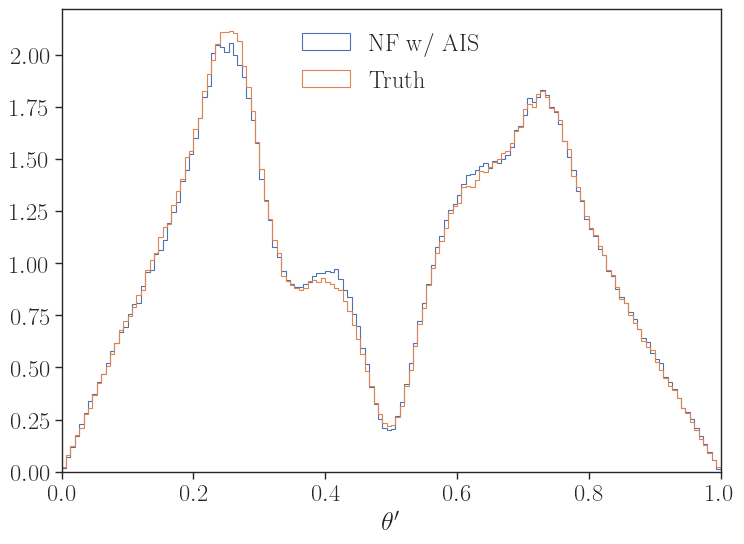

In [20]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
counts, edges, _ = ax.hist(samples_ais[:,1], 150, range = [0,1], histtype = 'step', label = r'$\mathrm{NF}$ $\mathrm{w/}$ $\mathrm{AIS}$', density = True)
ax.hist(samples_gt[:,1], bins = edges, range = [0,1], histtype = 'step', label = r'$\mathrm{Truth}$', density = True)
#ax.hist(samples_flow[:,1], 100, range = [0,1], histtype = 'step', label = r'$\mathrm{Flow}$')
ax.set_xlim(0,1)
ax.set_xlabel(r"$\theta'$")
ax.legend(frameon=False, fontsize = 'x-small', loc = 'upper center')
fig.tight_layout()
fig.savefig(r'NF_AIS_thetap_vs_truth.pdf', dpi = 300, pad_inches = .1, bbox_inches = 'tight')

## Flow with AIS reweighed

In [32]:
n_samples = 10000
samples_ais_weighted = []
weights = []
for _ in tqdm(range(100), ncols = 100):
    sample_ais_weight, weight = fab_model.annealed_importance_sampler.sample_and_log_weights(n_samples, logging=False)
    # Check that each sampled point is within the physical range (0,1), otherwise resample and replace
    #for j in range(n_samples):
    #    if sample_ais_weight.x[j,0] > 1.0 or sample_ais_weight.x[j,0] < 0.0 or sample_ais_weight.x[j,1] > 1.0 or sample_ais_weight.x[j,1] < 0.0:
    #        sample_ais_weight_i = sample_ais_weight[j]
    #        weight_i = weight[j]
    #        while sample_ais_weight_i.x[0] < 1.0 and sample_ais_weight_i.x[0] > 0.0 and sample_ais_weight_i.x[1] < 1.0 and sample_ais_weight_i.x[1] > 0.0:
    #            sample_ais_weight_i, weight_i = fab_model.annealed_importance_sampler.sample_and_log_weights(1, logging=False)
    #        sample_ais_weight.x[j] = sample_ais_weight_i.x[0]
    #        weight[j] = weight_i
    samples_ais_weighted.append(sample_ais_weight.x.detach())
    weights.append(np.exp(weight.detach().numpy()))

100%|█████████████████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.29it/s]


In [33]:
# Convert to numpy array
samples_ais_weighted = np.array(samples_ais_weighted)
print(samples_ais_weighted.shape)
# Flatten to desired shape
samples_ais_weighted = np.reshape(samples_ais_weighted, (samples_ais_weighted.shape[0] * samples_ais_weighted.shape[1], 2))
print(samples_ais_weighted.shape)
weights = np.array(weights).flatten()
print(weights.shape)

(100, 10000, 2)
(1000000, 2)
(1000000,)


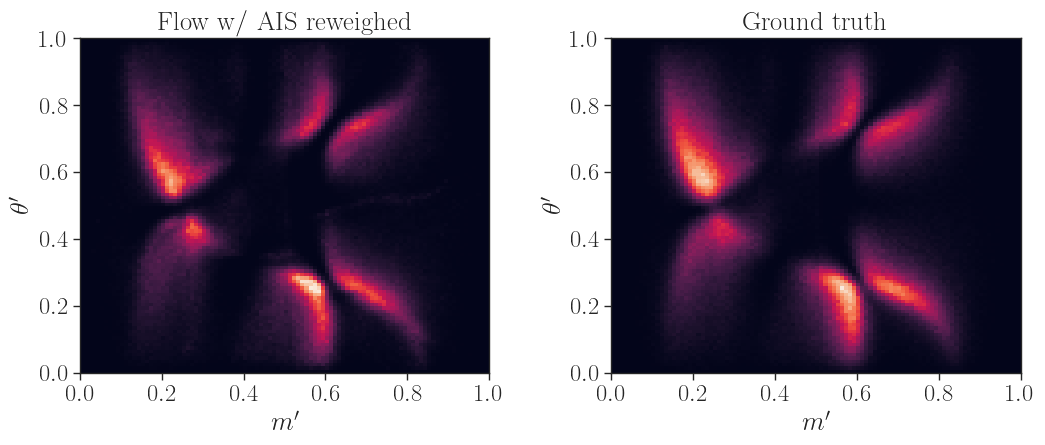

In [36]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(11,5))
H, xedges, yedges, im = ax1.hist2d(samples_ais_weighted[:,0], samples_ais_weighted[:,1], 100, range = [[0,1],[0,1]], weights = weights, density = True)
ax2.hist2d(samples_gt[:,0], samples_gt[:,1], bins = (xedges, yedges), density = True)
#ax1.set_xlim(0,1)
#ax1.set_ylim(0,1)
ax1.set_xlabel(r"$m'$")
ax1.set_ylabel(r"$\theta'$")
ax1.set_title(r'$\mathrm{Flow}$ $\mathrm{w/}$ $\mathrm{AIS}$ $\mathrm{reweighed}$')
ax2.set_xlabel(r"$m'$")
ax2.set_ylabel(r"$\theta'$")
ax2.set_title(r'$\mathrm{Ground}$ $\mathrm{truth}$')
fig.tight_layout()

In [75]:
print(H)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.04010623e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 4.05972319e-11 ... 1.33828562e-04
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


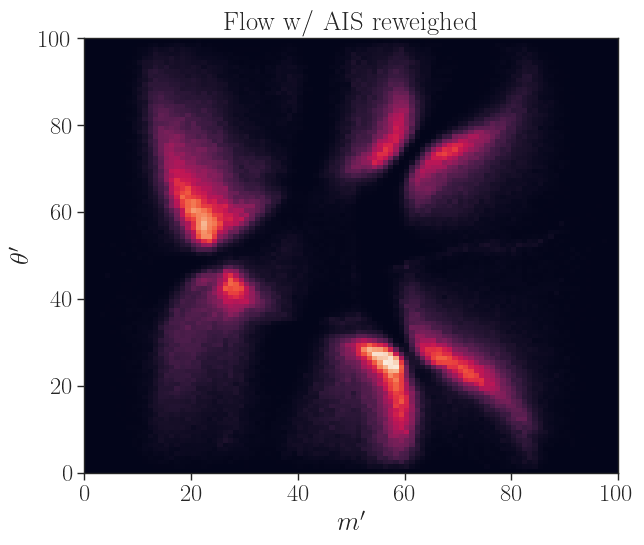

In [35]:
fig, ax = plt.subplots(1,1,figsize=(7,6))
ax.pcolormesh(H.T)
#ax.set_xlim(0,1)
#ax.set_ylim(0,1)
ax.set_xlabel(r"$m'$")
ax.set_ylabel(r"$\theta'$")
ax.set_title(r'$\mathrm{Flow}$ $\mathrm{w/}$ $\mathrm{AIS}$ $\mathrm{reweighed}$')
fig.tight_layout()

In [25]:
mp = np.array([np.sum(H[i]) for i in range(len(H[0]))])
thetap = np.array([np.sum(H[:,i]) for i in range(len(H[0]))])

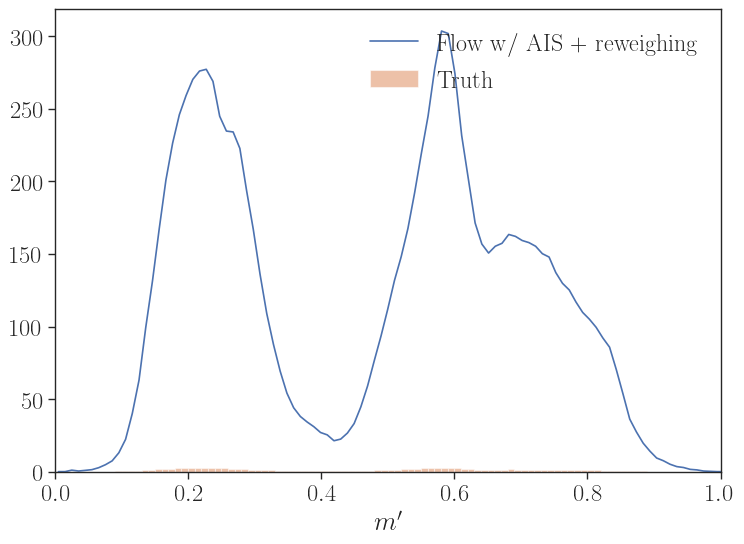

In [26]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
x = np.linspace(0.005,1.005,100)
ax.plot(x, mp / 100, label = r'$\mathrm{Flow}$ $\mathrm{w/}$ $\mathrm{AIS}$ $+$ $\mathrm{reweighing}$')
ax.hist(samples_gt[:,0], 100, range = [0,1], alpha = 0.5, label = r'$\mathrm{Truth}$', density = True)
ax.set_xlim(0,1)
ax.set_xlabel(r"$m'$")
ax.legend(frameon=False, fontsize = 'x-small')
fig.tight_layout()

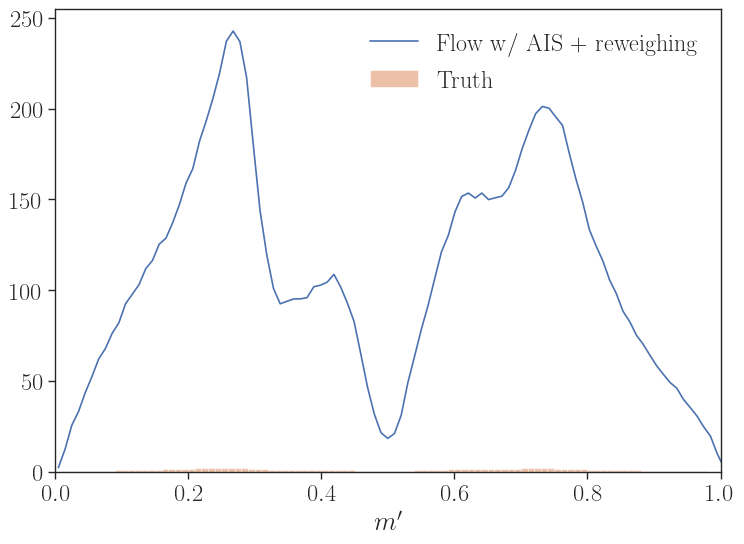

In [27]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
x = np.linspace(0.005,1.005,100)
ax.plot(x, thetap / 100, label = r'$\mathrm{Flow}$ $\mathrm{w/}$ $\mathrm{AIS}$ $+$ $\mathrm{reweighing}$')
ax.hist(samples_gt[:,1], 100, range = [0,1], alpha = 0.5, label = r'$\mathrm{Truth}$', density = True)
ax.set_xlim(0,1)
ax.set_xlabel(r"$m'$")
ax.legend(frameon=False, fontsize = 'x-small')
fig.tight_layout()